<a href="https://colab.research.google.com/github/vipashaaV321/User-Intent-Modeling/blob/main/Neural_Collaborative_Filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install sentence_transformers

In [ ]:
import os
import numpy as np
import pandas as pd
import random
import warnings
from tabulate import tabulate

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Dot, Flatten, Concatenate, Add
from sklearn.model_selection import train_test_split

from sentence_transformers import SentenceTransformer

import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
plt.rcParams.update({'pdf.fonttype': 'truetype'})
warnings.simplefilter("ignore")

In [ ]:
def print_df(df, col_width = 10, rows = 10, max_cols = 10):
    def short_srt(x):
        return x if len(x) < col_width else x[:col_width-3] + "..."
    df_short = df.head(rows).applymap(lambda x: short_srt(str(x)))

    if len(df_short.columns) > max_cols:
        df_short = df_short.iloc[:, 0:max_cols-1]
        df_short['...'] = '...'

    print(tabulate(df_short, headers='keys', tablefmt='psql'))
    print(f'{len(df)} rows x {len(df.columns)} columns')

def plot_keras_training_hitory(history):
    plt.plot(history.history['loss']);
    plt.plot(history.history['val_loss']);
    plt.xlabel('Training epoch')
    plt.ylabel('Loss')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.grid(True)

In [ ]:
from zipfile import ZipFile
from urllib.request import urlretrieve

In [ ]:
## extracting data
urlretrieve("http://files.grouplens.org/datasets/movielens/ml-20m.zip", "movielens.zip")
ZipFile("movielens.zip", "r").extractall()

In [ ]:
base_data_path = 'ml-20m'
items = pd.read_csv(base_data_path + '/movies.csv', sep=',', skiprows=1,
                     names=['item_id', 'title', 'genres'])
ratings = pd.read_csv(base_data_path + '/ratings.csv', sep=',', skiprows=1,
                      names=['user_id', 'item_id', 'rating', 'timestamp'])
tags = pd.read_csv(base_data_path + '/tags.csv', sep=',', skiprows=1,
                      names=['user_id', 'item_id', 'tag', 'timestamp'])

In [ ]:
tags

,user_id,item_id,tag,timestamp
0,18,4141,Mark Waters,1240597180
1,65,208,dark hero,1368150078
2,65,353,dark hero,1368150079
3,65,521,noir thriller,1368149983
4,65,592,dark hero,1368150078
...,...,...,...,...
465559,138446,55999,dragged,1358983772
465560,138446,55999,Jason Bateman,1358983778
465561,138446,55999,quirky,1358983778
465562,138446,55999,sad,1358983772


In [ ]:
tags_flat = tags[['item_id', 'tag']]\
    .groupby(by=['item_id'])['tag']\
    .apply(list)\
    .apply(lambda x: ' '.join(list(map(str, x))))\
    .apply(str.lower)
items = items.join(tags_flat, on='item_id')

In [ ]:
tags_flat

item_id
1         watched computer animation disney animated fea...
2         time travel adapted from:book board game child...
3         old people that is actually funny sequel fever...
4         chick flick revenge characters chick flick cha...
5         diane keaton family sequel steve martin weddin...
                                ...                        
131054                                            dinosaurs
131082                           documentary yoshitomo nara
131164                                          vietnam war
131170                                    alternate reality
131258                   bandits korea mutiny pirates whale
Name: tag, Length: 19545, dtype: object

In [ ]:
items

,item_id,title,genres,tag
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,watched computer animation disney animated fea...
1,2,Jumanji (1995),Adventure|Children|Fantasy,time travel adapted from:book board game child...
2,3,Grumpier Old Men (1995),Comedy|Romance,old people that is actually funny sequel fever...
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,chick flick revenge characters chick flick cha...
4,5,Father of the Bride Part II (1995),Comedy,diane keaton family sequel steve martin weddin...
...,...,...,...,...
27273,131254,Kein Bund für's Leben (2007),Comedy,NaN
27274,131256,"Feuer, Eis & Dosenbier (2002)",Comedy,NaN
27275,131258,The Pirates (2014),Adventure,bandits korea mutiny pirates whale
27276,131260,Rentun Ruusu (2001),(no genres listed),NaN


In [ ]:
# Remove movies with short tag lines
items = items[items['tag'].str.len() > 200]
ratings = ratings[ratings['item_id'].isin(items['item_id'].unique())]

In [ ]:
# Remove users with less than 50 ratings
ratings = ratings[ratings.groupby(by='user_id')['user_id'].transform('size') > 50]
ratings['rating'] = ratings['rating'].round(0).astype(int)

In [ ]:
# Remap user and item IDs to sequental integers
n_users, n_items = ratings['user_id'].nunique(), ratings['item_id'].nunique()
item_id_lookup = { old_id:new_id for (old_id, new_id) in zip(items['item_id'].values, np.arange(n_items)) }
items['item_id'] = items['item_id'].apply(lambda x: item_id_lookup[x])
ratings['item_id'] = ratings['item_id'].apply(lambda x: item_id_lookup[x])

In [ ]:
user_id_lookup = { old_id:new_id for (old_id, new_id) in zip(ratings['user_id'].unique(), np.arange(n_users)) }
ratings['user_id'] = ratings['user_id'].apply(lambda x: user_id_lookup[x])

In [ ]:
print_df(items, col_width = 30)
print_df(ratings)

+----+-----------+--------------------------------+--------------------------------+--------------------------------+
|    |   item_id | title                          | genres                         | tag                            |
|----+-----------+--------------------------------+--------------------------------+--------------------------------|
|  0 |         0 | Toy Story (1995)               | Adventure|Animation|Childre... | watched computer animation ... |
|  1 |         1 | Jumanji (1995)                 | Adventure|Children|Fantasy     | time travel adapted from:bo... |
|  2 |         2 | Grumpier Old Men (1995)        | Comedy|Romance                 | old people that is actually... |
|  4 |         3 | Father of the Bride Part II... | Comedy                         | diane keaton family sequel ... |
|  5 |         4 | Heat (1995)                    | Action|Crime|Thriller          | realistic action al pacino ... |
|  6 |         5 | Sabrina (1995)                 | Come

In [ ]:
user_ids, item_ids = ratings['user_id'].unique(), ratings['item_id'].unique()
max_user_id, max_item_id = max(ratings['user_id']), max(ratings['item_id'])
print(f'Max user id: {max_user_id}, max item id: {max_item_id}')

Max user id: 78407, max item id: 4743


In [ ]:
n = ratings.shape[0]
train_idx, test_idx, _, _ = train_test_split(np.arange(n), np.arange(n), test_size=0.20, random_state=42)

Model 1: Neural Collaborative Filtering (Factorization Network)

In this section, we train and evaluate a basic network that replicates the standard matrix factorization algorithm.

In [ ]:
x_train, x_test = ratings[['user_id', 'item_id']].values[train_idx], ratings[['user_id', 'item_id']].values[test_idx]
y_train, y_test = ratings['rating'].values[train_idx], ratings['rating'].values[test_idx]

In [ ]:
embedding_dim = 8

In [ ]:

input_user = Input(shape=(1,))
input_item = Input(shape=(1,))

In [ ]:
embedding_user = Embedding(input_dim=max_user_id + 1, output_dim=embedding_dim)(input_user)
embedding_item = Embedding(input_dim=max_item_id + 1, output_dim=embedding_dim)(input_item)

In [ ]:
combined = Dot(axes=2)([embedding_user, embedding_item])

In [ ]:
score = Dense(1, activation='linear')(combined)

In [ ]:
model_sgd = Model(inputs=[input_user, input_item], outputs=score)

Epoch 1/3
47889/47889 [==============================] - 531s 11ms/step - loss: 1.1053 - root_mean_squared_error: 1.0513 - val_loss: 1.0690 - val_root_mean_squared_error: 1.0339
Epoch 2/3
47889/47889 [==============================] - 507s 11ms/step - loss: 1.0666 - root_mean_squared_error: 1.0328 - val_loss: 1.0690 - val_root_mean_squared_error: 1.0339
Epoch 3/3
47889/47889 [==============================] - 519s 11ms/step - loss: 1.0666 - root_mean_squared_error: 1.0328 - val_loss: 1.0693 - val_root_mean_squared_error: 1.0341


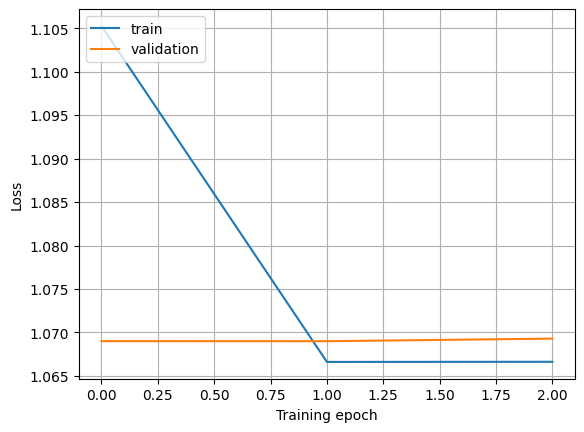

In [ ]:
# Model training
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model_sgd.compile(optimizer=opt, loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
history_sgd = model_sgd.fit([x_train[:, 0], x_train[:, 1]], y_train,
                    batch_size=256, epochs=3, verbose=1,
                    validation_data=([x_test[:, 0], x_test[:, 1]], y_test))

plot_keras_training_hitory(history_sgd)

In [ ]:
y_test_hat = model_sgd.predict([x_test[:, 0], x_test[:, 1]])[:, 0, 0]
plot_data = pd.DataFrame(np.vstack([y_test, y_test_hat]).T, columns=['Rating', 'Predicted rating'])
fig, ax = plt.subplots(1, figsize=(10, 6))
sns.violinplot(data=plot_data, x = "Rating", y = "Predicted rating", ax=ax)
plt.grid(True)

In [ ]:
def get_items(user_id):
    u_items = ratings[ratings['user_id'] == user_id].merge(items, on='item_id', how='left')
    return u_items[['title', 'rating']].sort_values(by=['rating'], ascending=False)

In [ ]:
def recommend_for_user(model, user_id, k):
    x1, x2 = np.repeat(user_id, n_items), item_ids
    ratings = model.predict([x1, x2]).ravel()
    top_k_indexes = ratings.argsort()[-k:][::-1]
    return x2[top_k_indexes], ratings[top_k_indexes]

In [ ]:
def show_recommendations(r_items, r_ratings):
    r = pd.DataFrame(data=np.vstack([r_items, r_ratings]).T, columns=['item_id', 'rating'])
    print_df(r.merge(items, on='item_id', how='left')[['title', 'rating']], col_width = 50)

In [ ]:
user_id = 0
k_recomendations = 10
print_df(get_items(user_id), col_width = 50, rows = 10)
r_items, r_ratings = recommend_for_user(model_sgd, user_id, k_recomendations)
show_recommendations(r_items, r_ratings)

+-----+----------------------------------------------------+----------+
|     | title                                              |   rating |
|-----+----------------------------------------------------+----------|
| 121 | Lord of the Rings: The Fellowship of the Ring, ... |        5 |
| 155 | Freaks (1932)                                      |        5 |
| 131 | Lord of the Rings: The Two Towers, The (2002)      |        5 |
| 145 | Lord of the Rings: The Return of the King, The ... |        5 |
|   0 | Jumanji (1995)                                     |        4 |
| 106 | O Brother, Where Art Thou? (2000)                  |        4 |
| 100 | Hook (1991)                                        |        4 |
| 101 | Misery (1990)                                      |        4 |
| 103 | Crouching Tiger, Hidden Dragon (Wo hu cang long... |        4 |
| 104 | Dungeons & Dragons (2000)                          |        4 |
+-----+----------------------------------------------------+----

## TEXT Features

Model 2: Network with Item Features

In this section, we build a simple extension of the basic neural collaborative filtering network to incroporate embeddigns produced based movie tags.

We create item embeddigns by concatenating all movie tags into pseudo-sentence and encoding it using a pre-trained MiniLM model

In [ ]:
text_model = SentenceTransformer('all-MiniLM-L6-v2')
items['item_features'] = items['tag'].transform(text_model.encode)

item_features_r = ratings.merge(items[['item_id', 'item_features']], on='item_id')['item_features']
item_features_r = np.vstack(item_features_r)
print(f'Item features shape: {item_features_r.shape}')
feature_dim = item_features_r.shape[1]

x1_train, x2_train, x3_train = ratings['user_id'].values[train_idx], ratings['item_id'].values[train_idx], item_features_r[train_idx]
x1_test, x2_test, x3_test = ratings['user_id'].values[test_idx], ratings['item_id'].values[test_idx], item_features_r[test_idx]
y_train, y_test = ratings['rating'].values[train_idx], ratings['rating'].values[test_idx]

del item_features_r

In [ ]:
def model_hybrid(embedding_dim):
    input_user = Input(shape=(1,))
    input_item = Input(shape=(1,))
    input_item_e = Input(shape=(feature_dim,))

    embedding_user = Embedding(input_dim=max_user_id + 1, output_dim=embedding_dim)(input_user)
    embedding_item = Embedding(input_dim=max_item_id + 1, output_dim=embedding_dim)(input_item)

    #e1 = Flatten()(embedding_user)
    #e2 = Flatten()(embedding_item)
    e1 = embedding_user
    e2 = embedding_item

    t = Dense(embedding_dim, activation='relu')(input_item_e)
    e2 = Add()([e2, t])
    #e2 = Dense(embedding_dim, activation='relu')(e2)

    combined = Dot(axes=2)([e1, e2])
    rating = Dense(1, activation='linear')(combined)

    model = Model(inputs=[input_user, input_item, input_item_e], outputs=rating)

    return model

In [ ]:
# Model training
#
model_hybrid_k = model_hybrid(embedding_dim = 8)
model_hybrid_k.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
history_hybrid = model_hybrid_k.fit([x1_train, x2_train, x3_train], y_train,
                           batch_size=256,
                           epochs=16,
                           validation_data=([x1_test, x2_test, x3_test], y_test),
                           verbose=1)
plot_keras_training_hitory(history_hybrid)

In [ ]:
def recommend_for_user_hybrid(model, user_id, k):
    x1, x2, x3 = np.repeat(user_id, n_items), item_ids, np.vstack(items['item_features'].values)
    ratings = model.predict([x1, x2, x3]).ravel()
    top_k_indexes = ratings.argsort()[-k:][::-1]
    return x2[top_k_indexes], ratings[top_k_indexes]

In [ ]:
# Generate recommendations for an example user
#
user_id = 0
k_recomendations = 10
print_df(get_items(user_id), col_width = 50, rows = 10)
r_items, r_ratings = recommend_for_user_hybrid(model_hybrid_k, user_id, k_recomendations)
show_recommendations(r_items, r_ratings)